# Example 1: 2-D fault network extraction from a numerical model
This example describes how to extract a 2-D fault network from a numerical model simulating continental rifting. This example is based on the study of Naliboff et al. (2020).

Now we can load the python packages that we need:

In [48]:
import numpy as np 
import networkx as nx
import pickle
import cv2
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance_matrix

from sys import stdout

from fatbox.preprocessing import simple_threshold_binary, skeleton_guo_hall, array_to_points
from fatbox.edits import label_components, simplify
from fatbox.plots import plot_components
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})

## Fault extraction

First, we load our data - a strain rate map extracted just below the surface of the model:

In [84]:
#strain_rate = np.load('NearSurfaceIsotherm_335K_strain_rate.npy')
#strain_rate = np.genfromtxt('Lake_drop_restart_71_1000m_step179_MEII_zoom.txt')
strain_rate = np.genfromtxt('/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/\
Lake_drop_restart_71_1000m_step179_x_50-190_y_15-38_MEII_zoom.txt')
#strain_rate = strain_rate[:400,0:400]

Now we can plot it to look the faults in the model

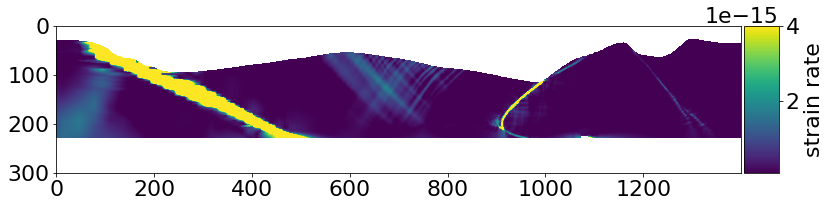

In [86]:
fig,ax = plt.subplots(figsize=(12,12))


#plt.axis('off')
#divider = make_axes_locatable(ax)
#cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
# fig.add_axes(cax)
# fig.colorbar(im, cax=cax, orientation="horizontal")
# plt.show()
#ax.colorbar(label = 'strain rate')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(strain_rate, origin= 'upper', vmax = 4e-15, vmin = 1e-16)
fig.colorbar(im, cax=cax, orientation='vertical', label = 'strain rate')
ax.set_ylim([300, 0])
plt.tight_layout()

Next we want to separate the faults from the background using a threshold:

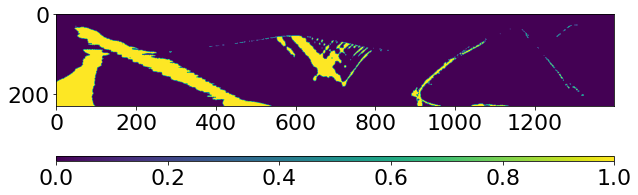

In [151]:
threshold = simple_threshold_binary(strain_rate, 8e-16)

fig, ax = plt.subplots(figsize=(10,20))
#fig = plt.figure()
im = ax.imshow(threshold, vmin=0, vmax=1)
#plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

Now we can reduce the areas above the threshold to lines using a skeletonize algorithm:

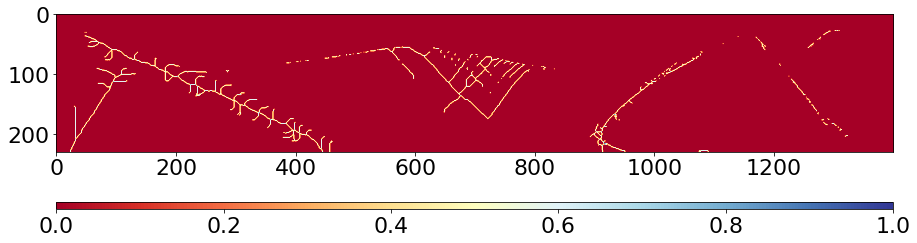

In [152]:
skeleton = skeleton_guo_hall(threshold)

fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(skeleton, vmin=0, vmax=1,cmap = 'RdYlBu')
#plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

Now we can convert these lines to points:

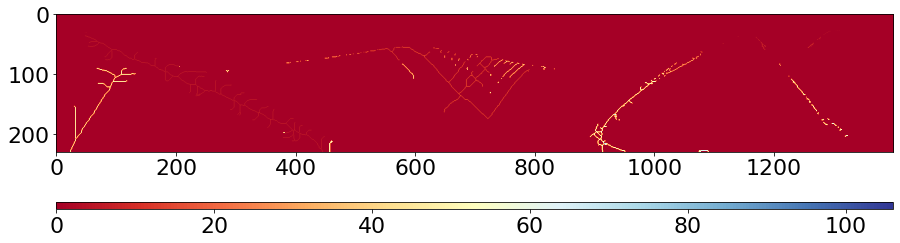

In [153]:
ret, markers = cv2.connectedComponents(skeleton)

fig, ax = plt.subplots(figsize=(15,10))
im = ax.imshow(markers, vmin=0, origin = 'upper',
              cmap = 'RdYlBu')
#plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
fig.add_axes(cax)
fig.colorbar(im, cax=cax, orientation="horizontal")
plt.show()

These points become the nodes of our graph G:

In [154]:
G = nx.Graph()

node = 0
for comp in range(1,ret):

    points = np.transpose(np.vstack((np.where(markers==comp))))    
    
    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1    

Remember a graph is an object consisting only of nodes and edges. Our graph for example looks like this:

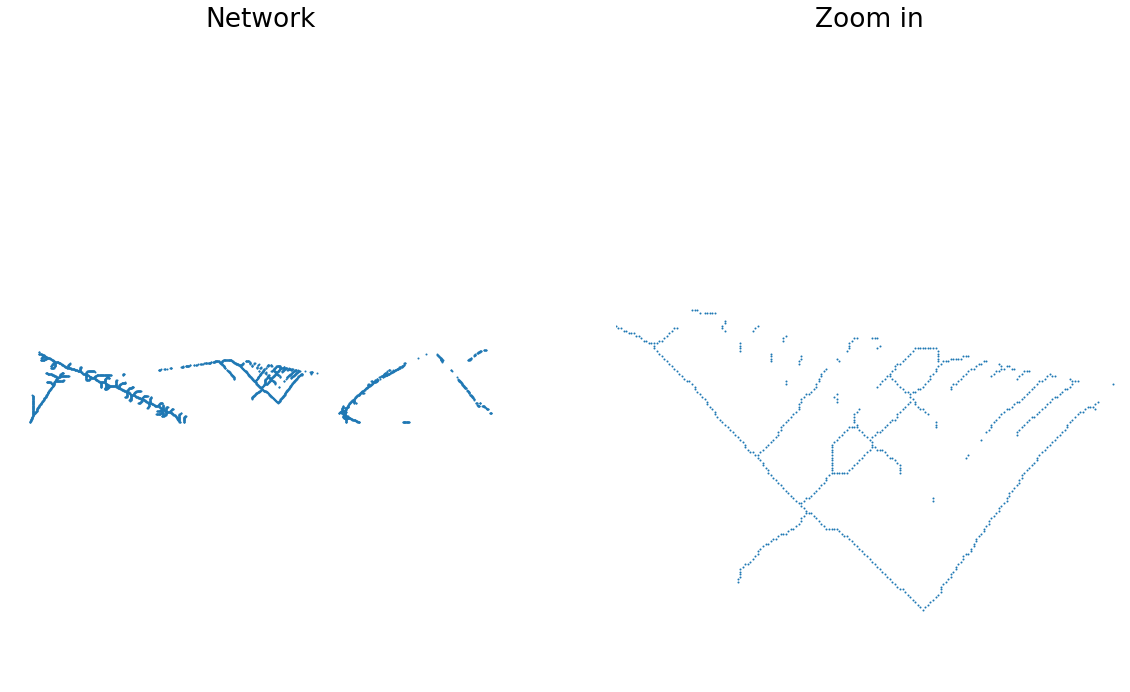

In [155]:
fig, axs = plt.subplots(1, 2, figsize=(20,12))

axs[0].set_title('Network')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')
axs[0].set_ylim([100, 0])


axs[1].set_title('Zoom in')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_ylim([100, 50])
axs[1].set_xlim([600, 800])

plt.show()

You can see that the graph only consists of closely spaced points, which are not yet connected. So let's change that!


We calculate the distance between all nodes of a component in a distance matrix and connect the ones close to each other (<1.5 pixels away):

In [156]:
for comp in range(1,ret): 
    
    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  
    
    
    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):
            if dm[n,m]<1.5 and n != m:
                G.add_edge(nodes[n],nodes[m])

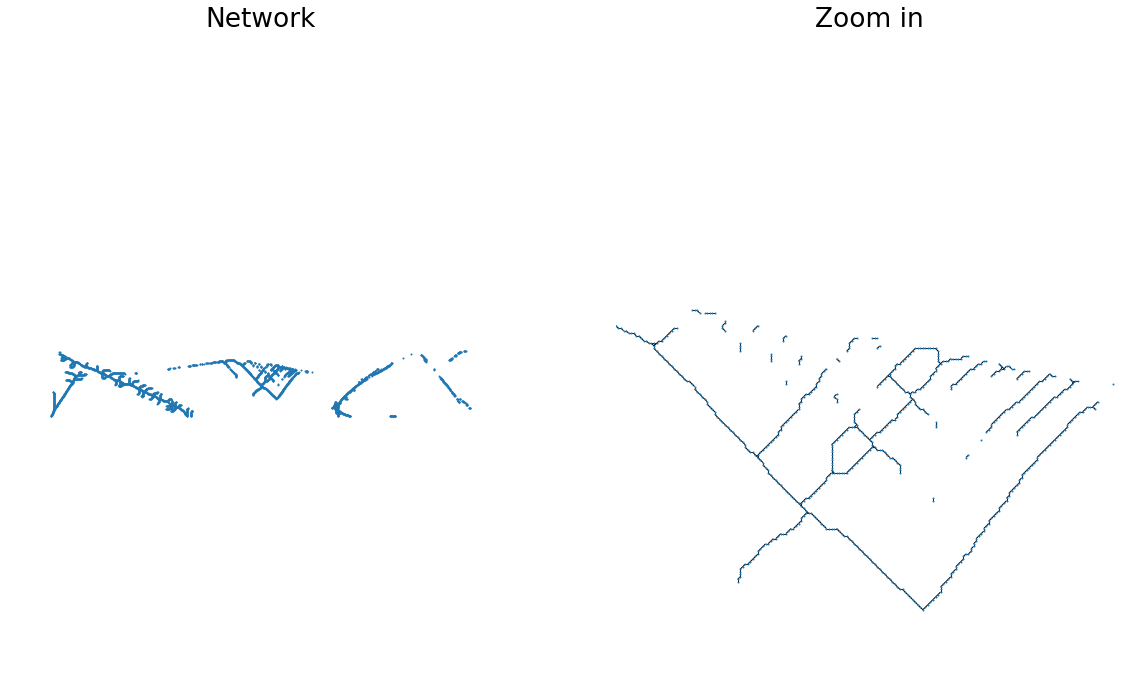

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(20,12))

axs[0].set_title('Network')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')
axs[0].set_ylim([100, 0])


axs[1].set_title('Zoom in')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'), 
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_ylim([100, 50])
axs[1].set_xlim([600, 800])

plt.show()

Now we can see that neighboring nodes are connected by edges (black lines). This allows us to label the nodes connected to one another as components:

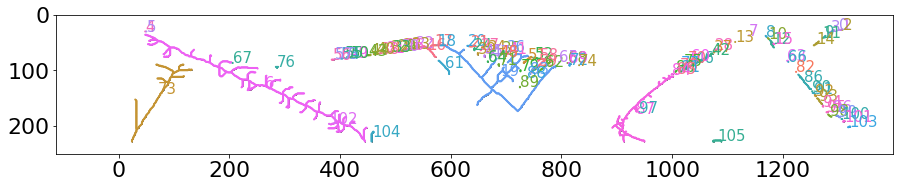

In [158]:
G = label_components(G)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(strain_rate), 'gray_r', vmin=0)
plot_components(G, node_size=1, ax=ax)
# ax.set_xlim(0,400)
# ax.set_ylim(0, 100)
plt.show()

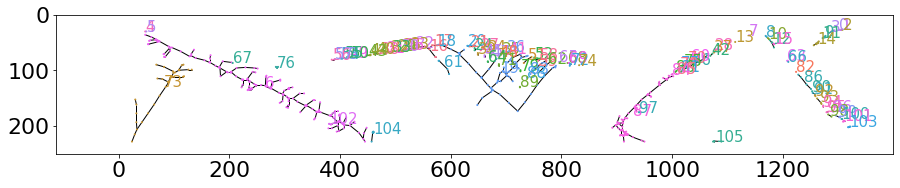

In [160]:
G = simplify(G, 2)

fig, ax = plt.subplots(1, 1, figsize=(15,15))
ax.imshow(np.zeros_like(strain_rate), 'gray_r', vmin=0)
plot_components(G, node_size=1, ax=ax)
# ax.set_xlim(600,800)
# ax.set_ylim(150,50)
plt.show()

## Structure of the network
Let's have a look at the structure of the fault network (or graph). Remember it only consists of nodes and edges. So let's have a look at the nodes:

Okay, nothing special here, just a list of the nodes. Let's pick out one:

Nice! Let's do that for all nodes:

In [161]:
for node in G.nodes:
  G.nodes[node]['strain_rate'] = strain_rate[int(G.nodes[node]['pos'][1]), int(G.nodes[node]['pos'][0])]

and plot it:

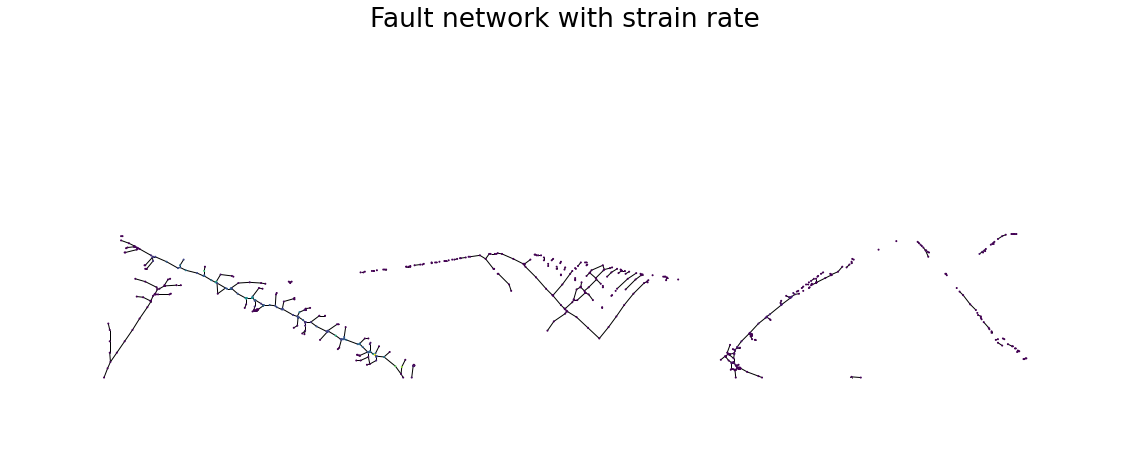

In [162]:
fig, ax = plt.subplots(figsize=(20,8))

ax.set_title('Fault network with strain rate')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        node_color = np.array([G.nodes[node]['strain_rate'] for node in G.nodes]), 
        node_size=1,
        ax=ax)
ax.axis('equal')
ax.set_ylim(100, 0)
plt.show()

Like this we can compute and visualize all kinds of properties on the fault network.

But what about the edges?

Alright, just tuples of nodes. Let's pick one:

Okay, they have no property yet. Let's calculate its length:

Again, we can do this for all edges:

In [163]:
for edge in G.edges:
  G.edges[edge]['length'] = np.linalg.norm(np.array(G.nodes[edge[0]]['pos'])-np.array(G.nodes[edge[1]]['pos']))

and plot it:

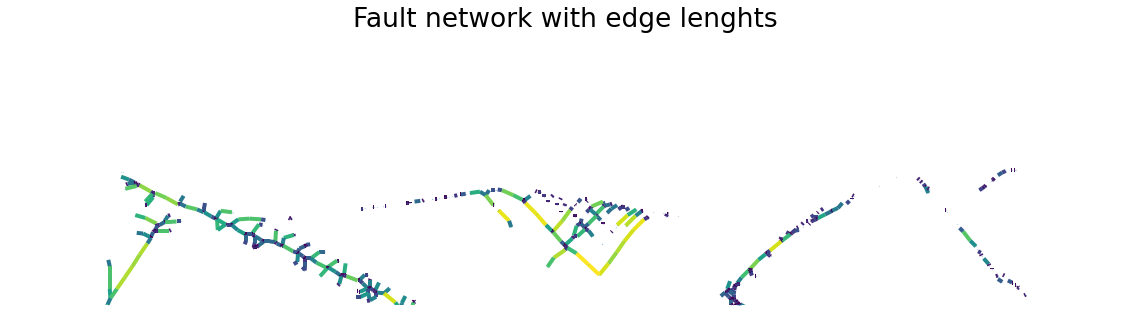

In [164]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_title('Fault network with edge lenghts')
nx.draw(G, 
        pos=nx.get_node_attributes(G, 'pos'),
        edge_color = np.array([G.edges[edge]['length'] for edge in G.edges]), 
        node_size=0.01,
        with_labels = False,
        width = 4,
        ax=ax)
ax.axis('equal')
ax.set_ylim(50, 0)
plt.show()

Awesome! That's it. You've extracted your first fault network. In the next tutorial, we will learn how to compute and visualize fault strikes:
https://github.com/thilowrona/fault_analysis_toolbox/blob/master/examples/2-fault_properties/2-fault_properties.ipynb 

In [166]:
# save it as pickle
with open('/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/test.p', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [80]:
G = pickle.load(open('data.p', 'rb'))          

In [168]:
G.nodes[1]


{'pos': (1302, 27), 'component': 0, 'strain_rate': 2.2222e-15}

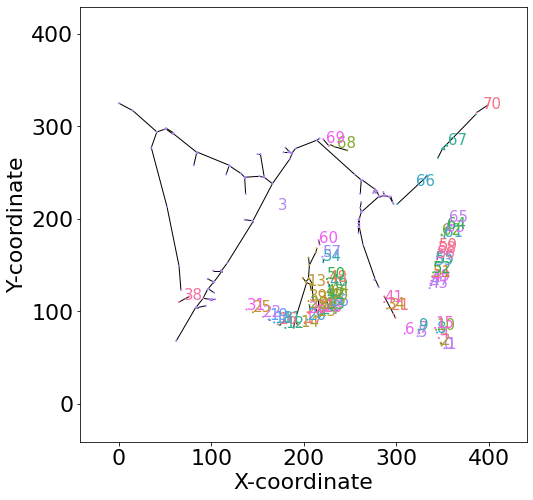

In [85]:
fig, ax = plt.subplots(figsize=(8,8))
plot_components(G, ax = ax, node_size=1.0)
ax.axis('equal')
ax.set_xlabel('X-coordinate')
ax.set_ylabel('Y-coordinate')
plt.show()